In [6]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.optim.lr_scheduler import StepLR,ExponentialLR,CosineAnnealingLR
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

import itertools

In [7]:
# Adjust the model to get a higher performance
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()# batch*1*28*28（每次会送入batch个样本，输入通道数1（黑白图像），图像分辨率是28x28）
        #in_channels=1,out_channels=8,kernel_size=3,stride=1
        self.conv1 = nn.Conv2d(1, 8, 3, 1)# 输出数据大小变为28-3+1=26.所以batchx1x28x28 -> batchx8x26x26   
        self.conv2 = nn.Conv2d(8, 16, 3, 1)#第一个卷积层的输出通道数等于第二个卷积层的输入通道数。
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(2304, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)#（激活函数ReLU不改变形状）
        x = self.conv2(x)  
        x = F.relu(x)#（激活函数ReLU不改变形状）
        x = F.max_pool2d(x, 2)# batch*8x26x26  -> batch*8*13*13（2*2的池化层会减半，步长为2）此时输出数据大小变为13-3+2=12（卷积核大小为3），所以 batchx8x13x13 -> batchx16x12x12。
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [10]:
train_accs = []
def train(args, model, device, train_loader, optimizer, epoch):# 定义每个epoch的训练细节
    total = 0
    running_loss = 0
    accuracy = 0 #记录每次epoch的accuracy
    model.train() # 设置为trainning模式
    plt.figure()
    pic = None

    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx in (1,2,3,4,5):
            if batch_idx == 1:
                pic = data[0,0,:,:]
            else:
                pic = torch.cat((pic,data[0,0,:,:]),dim=1)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()# 优化器梯度初始化为零
        # forword + backward + update
        output = model(data)# 把数据输入网络并得到输出，即进行前向传播
        loss = F.cross_entropy(output, target) # 计算损失函数 
        _, predicted = torch.max(output.data, dim=1)
        if batch_idx == 1:
            images = utils.make_grid(data,padding = 0)
            image_show(images)
            print('GroundTruth: ', ' '.join('%d' % target[j] for j in range(64)))
            print('Predicted: ', ' '.join('%d' % predicted[j] for j in range(64)))
        accuracy += (predicted == target).sum().item()
        total += target.size(0)

        # Calculate gradients
        loss.backward()# 反向传播梯度
        
        # Optimize the parameters according to the calculated gradients
        optimizer.step()# 结束一次前传+反传之后，更新优化器参数
        
        running_loss += loss.item()
        
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break

    train_accs.append(100 * accuracy/total)    
    plt.imshow(pic.cpu(), cmap='gray')
    plt.show()


In [11]:
def image_show(images):
    images = images.numpy()
    images = images.transpose((1, 2, 0))
    print(images.shape)
    plt.imshow(images)
    plt.show()

In [12]:
test_accs = [] 

def test(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0
    test_loss= 0
    conf_matrix = torch.zeros(10, 10)
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            #conf_matrix = confusion_matrix(output, target, conf_matrix)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # sum up batch loss
            _, predicted = torch.max(output.data, dim=1)  # get the index of the max log-probability

            if batch_idx == 1:
                #images = utils.make_grid(data,padding = 0)
                #image_show(images)
                print('GroundTruth: ', ' '.join('%d' % target[j] for j in range(64)))
                print('Predicted: ', ' '.join('%d' % predicted[j] for j in range(64)))
            total += target.size(0)
            correct += (predicted == target).sum().item()# 对预测正确的数据个数进行累加
            # 不同类别的数量统计（区别于总体）
            c = (predicted == target)
            for i in range(10):
                lable = target[i]
                class_correct[lable] += c[i].sum().item()
                class_total[lable] += 1
            print(class_correct[i])
            
    test_loss /= len(test_loader.dataset)   # 因为把所有loss值进行过累加，所以最后要除以总得数据长度才得平均los
                                            # 将变量值或属性值除以表达式值，并将浮点数结果赋给该变量或属性
                                            # variableorproperty /= expression  
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    for i in range(10):
        print('Accuracy of %0f : %2d %%' % 
                (i, 100* class_correct[i]
                / class_total[i]))
        
    print(conf_matrix)
    #plt.figure(figsize=(10,10))
    #plot_confusion_matrix(conf_matrix, names)


    test_accs.append(100 * correct / total)

In [13]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
 
 
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
 
    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
 
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [14]:
names = ("0","1","2","3","4", "5","6","7","8","9")

In [15]:
def confusion_matrix(preds, labels, conf_matrix):
    preds = torch.argmax(preds, 1)
    for p,t in zip(preds,labels):
        conf_matrix[p,t] += 1
    return conf_matrix

In [16]:
def main():
    # Training settings
    
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',  #  64-640
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=14, metavar='N',   #14-50
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    parser.add_argument('-f', type=str, default="读取额外的参数")
    args = parser.parse_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    # batch_size is a crucial hyper-parameter
    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        # Adjust num worker and pin memory according to your computer performance
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    # Normalize the input (black and white image)
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    # Make train dataset split
    dataset1 = datasets.MNIST("mnist-data", train=True, download=True,
                       transform=transform)
    # Make test dataset split
    dataset2 = datasets.MNIST("mnist-data", train=False,
                       transform=transform)

    # Convert the dataset to dataloader, including train_kwargs and test_kwargs
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)
    
    # Put the model on the GPU or CPU
    model = Net().to(device)
     
    '''
   #这部分还没有跑通 但思路是这样
    # 导入Pytorch中自带的resnet18网络模型
    model_ft = models.resnet18(pretrained=True)
    
    # 将网络模型的各层的梯度更新置为False
    for param in model_ft.parameters():
        param.requires_grad = False
 
    # 修改网络模型的最后一个全连接层
    # 获取最后一个全连接层的输入通道数
    num_ftrs = model_ft.fc.in_features
    # 修改最后一个全连接层的的输出数为10（0-9的数字）
    model_ft.fc = nn.Linear(num_ftrs, 10)
    # 是否使用gpu
    if use_gpu:
        model_ft = model_ft.cuda()
 
    # 定义网络模型的损失函数
    criterion = nn.CrossEntropyLoss()
 
    # 只训练最后一个层
    # Create optimizer
    optimizer = optim.Adadelta(model_ft.fc.parameters(), lr=args.lr/10)#The general approach is to make the initial learning rate 10 times smaller than that of Training from scratch.

    '''
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr,)
    #optimizer = optim.Adam(model.parameters(), lr=args.lr, betas=(0.9,0.99))
    # 定义四个不同的优化器
    #optimizer = optim.SGD(model.parameters(), lr=args.lr)
    #optimizer = optim.SGD(model.parameters(),lr=args.lr, momentum=0.8)
    #optimizer = optim.RMSprop(model.parameters(), lr=args.lr, alpha=0.9)
    #optimizer = optim.Adam(model.parameters(), lr=args.lr, betas=(0.9,0.99))

    # Create a schedule for the optimizer
    #scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    #scheduler = ExponentialLR(optimizer, gamma=args.gamma)
    scheduler= CosineAnnealingLR(optimizer,T_max=20,eta_min=0.05)
    # Begin training and testing
    epochs = []
    for epoch in range(1, args.epochs + 1):
        epochs.append(epoch)
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

              
    print(epochs) 
    print(test_accs)
    print(train_accs)
    
   
    plt.plot(epochs,train_accs,color='r',label='train_acc')        
    plt.plot(epochs,test_accs,color='b',label='test_acc')  
    plt.xlabel('epochs')    
    plt.ylabel('accuracy')   
    plt.title("change of train(test) accuracy")      
    plt.legend()     
    plt.savefig('test.jpg')  
    plt.show()               

    # Save the model
    if args.save_model == True:
        torch.save(model.state_dict(), "D://INT305//model//mnist_cnn.pt")
        



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.296620
(224, 224, 3)


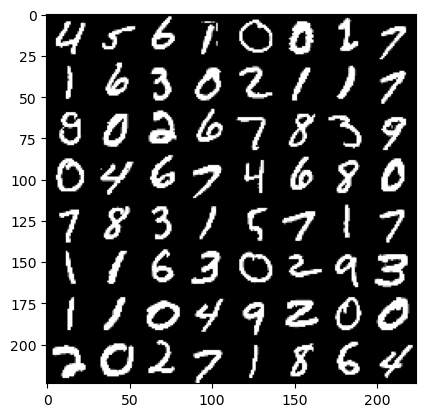

GroundTruth:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Predicted:  9 3 3 3 3 9 9 9 3 9 9 3 9 3 3 3 9 9 3 3 9 9 3 3 3 3 3 3 4 3 9 9 9 0 9 3 9 3 3 3 9 3 9 3 0 3 3 3 9 3 0 0 9 9 3 9 3 9 3 0 4 9 3 3
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.778122
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.287948
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.846328
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.726883
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.792199
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.381824
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.529886
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.630893
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.390645
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.250518
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.413878
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.309315
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.274730
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.281487
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0

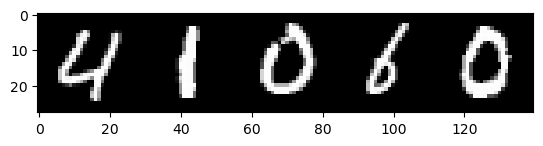

2.0
GroundTruth:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 6 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 7 1 5 3 4 6 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
Predicted:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 5 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 1 0 6 2 1 1 2 1 5 3 4 6 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 7 9
4.0
5.0
8.0
10.0
13.0
14.0
15.0
18.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18.0

Test set: Average loss: 0.0623, Accuracy: 9804/10000 (98%)

Accuracy of 0.000000 : 100 %
Accuracy of 1.000000 : 100 %
Accuracy of 2.000000 : 100 %
Accuracy of 3.000000 : 100 %
Accuracy of 4.000000 : 100 %
Accuracy of 5.000000 : 100 %
Accuracy of 6.000000 : 100 %
Accuracy of 7.000000 : 80 %
Accuracy of 8.000000 : 100 %
Accuracy of 9.000000 : 94 %
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.137756
(224, 224, 3)


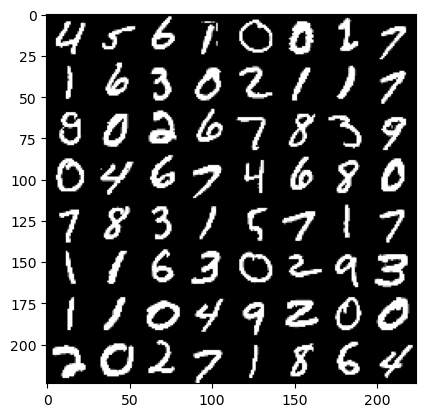

GroundTruth:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Predicted:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 5 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.055219
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.085263
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.109635
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.078341
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.157901
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.055639
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.087567
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.233641
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.049542
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.190046
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.243122
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.149999
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.048220
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.297363
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0

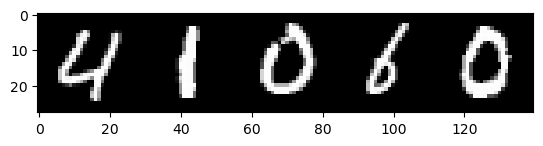

2.0
GroundTruth:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 6 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 7 1 5 3 4 6 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
Predicted:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 5 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 1 0 6 2 1 1 2 1 5 3 4 6 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
4.0
5.0
9.0
11.0
14.0
15.0
16.0
19.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19.0

Test set: Average loss: 0.0447, Accuracy: 9857/10000 (99%)

Accuracy of 0.000000 : 100 %
Accuracy of 1.000000 : 100 %
Accuracy of 2.000000 : 100 %
Accuracy of 3.000000 : 100 %
Accuracy of 4.000000 : 100 %
Accuracy of 5.000000 : 100 %
Accuracy of 6.000000 : 100 %
Accuracy of 7.000000 : 80 %
Accuracy of 8.000000 : 100 %
Accuracy of 9.000000 : 100 %
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.050506
(224, 224, 3)


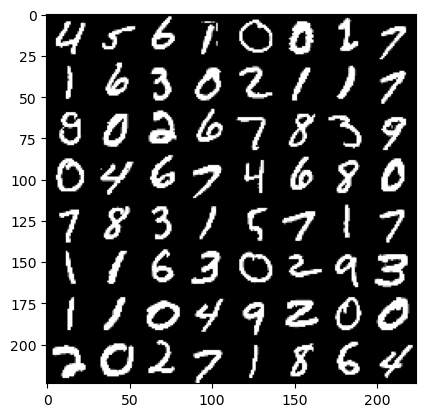

GroundTruth:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Predicted:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 0 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Train Epoch: 3 [640/60000 (1%)]	Loss: 0.027914
Train Epoch: 3 [1280/60000 (2%)]	Loss: 0.076687
Train Epoch: 3 [1920/60000 (3%)]	Loss: 0.146960
Train Epoch: 3 [2560/60000 (4%)]	Loss: 0.088287
Train Epoch: 3 [3200/60000 (5%)]	Loss: 0.062007
Train Epoch: 3 [3840/60000 (6%)]	Loss: 0.014279
Train Epoch: 3 [4480/60000 (7%)]	Loss: 0.020616
Train Epoch: 3 [5120/60000 (9%)]	Loss: 0.172113
Train Epoch: 3 [5760/60000 (10%)]	Loss: 0.105208
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.114262
Train Epoch: 3 [7040/60000 (12%)]	Loss: 0.014319
Train Epoch: 3 [7680/60000 (13%)]	Loss: 0.077479
Train Epoch: 3 [8320/60000 (14%)]	Loss: 0.038419
Train Epoch: 3 [8960/60000 (15%)]	Loss: 0.028750
Train Epoch: 3 [9600/60000 (16%)]	Loss: 0

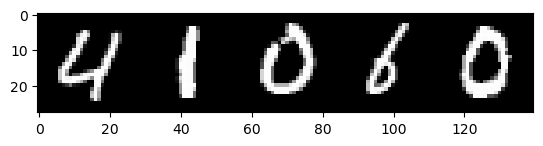

2.0
GroundTruth:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 6 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 7 1 5 3 4 6 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
Predicted:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 5 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 2 1 5 3 4 6 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
4.0
5.0
8.0
10.0
13.0
14.0
15.0
18.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18.0

Test set: Average loss: 0.0450, Accuracy: 9869/10000 (99%)

Accuracy of 0.000000 : 100 %
Accuracy of 1.000000 : 100 %
Accuracy of 2.000000 : 100 %
Accuracy of 3.000000 : 100 %
Accuracy of 4.000000 : 100 %
Accuracy of 5.000000 : 100 %
Accuracy of 6.000000 : 100 %
Accuracy of 7.000000 : 80 %
Accuracy of 8.000000 : 100 %
Accuracy of 9.000000 : 94 %
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.044231
(224, 224, 3)


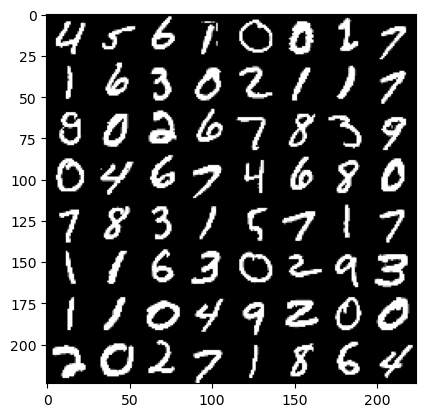

GroundTruth:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Predicted:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 8 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 0 0 2 7 1 8 6 4
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.066623
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.075115
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.152100
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.107645
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.047581
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.016483
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.029099
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.105219
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.065685
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.250031
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.131206
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.038689
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.082028
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.065729
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0

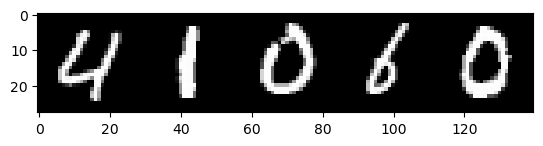

2.0
GroundTruth:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 6 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 7 1 5 3 4 6 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
Predicted:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 5 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 1 1 5 3 4 6 4 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
4.0
5.0
8.0
10.0
13.0
14.0
15.0
18.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18.0

Test set: Average loss: 0.0401, Accuracy: 9872/10000 (99%)

Accuracy of 0.000000 : 100 %
Accuracy of 1.000000 : 100 %
Accuracy of 2.000000 : 100 %
Accuracy of 3.000000 : 100 %
Accuracy of 4.000000 : 100 %
Accuracy of 5.000000 : 100 %
Accuracy of 6.000000 : 100 %
Accuracy of 7.000000 : 90 %
Accuracy of 8.000000 : 100 %
Accuracy of 9.000000 : 94 %
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Train Epoch: 5 [0/60000 (0%)]	Loss: 0.048770
(224, 224, 3)


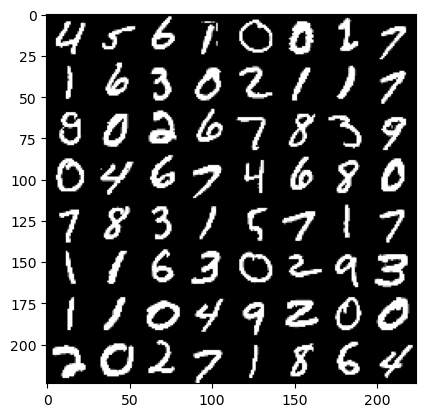

GroundTruth:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Predicted:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 0 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.052149
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.047774
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.055879
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.062778
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.162688
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.010134
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.043855
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.092841
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.100585
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.205395
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.143841
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.039076
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.018226
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.054161
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0

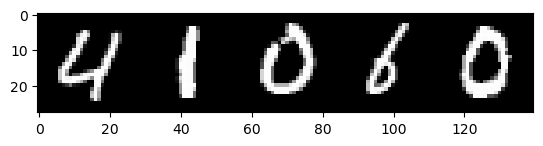

2.0
GroundTruth:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 6 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 7 1 5 3 4 6 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
Predicted:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 5 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 3 1 5 3 4 6 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
4.0
5.0
8.0
10.0
13.0
14.0
15.0
18.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


18.0

Test set: Average loss: 0.0426, Accuracy: 9870/10000 (99%)

Accuracy of 0.000000 : 100 %
Accuracy of 1.000000 : 100 %
Accuracy of 2.000000 : 100 %
Accuracy of 3.000000 : 100 %
Accuracy of 4.000000 : 100 %
Accuracy of 5.000000 : 100 %
Accuracy of 6.000000 : 100 %
Accuracy of 7.000000 : 90 %
Accuracy of 8.000000 : 100 %
Accuracy of 9.000000 : 94 %
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Train Epoch: 6 [0/60000 (0%)]	Loss: 0.060644
(224, 224, 3)


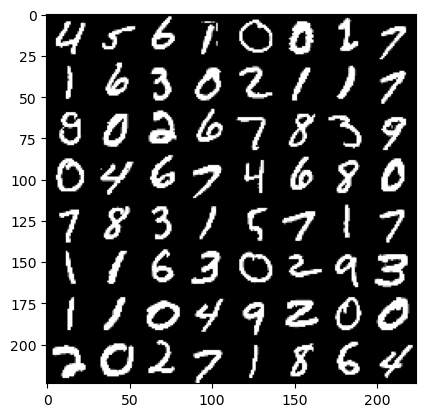

GroundTruth:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Predicted:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 8 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Train Epoch: 6 [640/60000 (1%)]	Loss: 0.001954
Train Epoch: 6 [1280/60000 (2%)]	Loss: 0.006022
Train Epoch: 6 [1920/60000 (3%)]	Loss: 0.166788
Train Epoch: 6 [2560/60000 (4%)]	Loss: 0.139026
Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.051435
Train Epoch: 6 [3840/60000 (6%)]	Loss: 0.012748
Train Epoch: 6 [4480/60000 (7%)]	Loss: 0.060206
Train Epoch: 6 [5120/60000 (9%)]	Loss: 0.177839
Train Epoch: 6 [5760/60000 (10%)]	Loss: 0.073423
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.067193
Train Epoch: 6 [7040/60000 (12%)]	Loss: 0.103519
Train Epoch: 6 [7680/60000 (13%)]	Loss: 0.012216
Train Epoch: 6 [8320/60000 (14%)]	Loss: 0.018216
Train Epoch: 6 [8960/60000 (15%)]	Loss: 0.236543
Train Epoch: 6 [9600/60000 (16%)]	Loss: 0

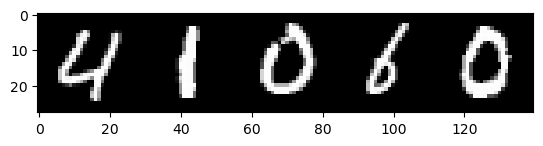

2.0
GroundTruth:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 6 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 7 1 5 3 4 6 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
Predicted:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 5 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 3 1 5 3 4 6 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
4.0
5.0
9.0
11.0
14.0
15.0
16.0
19.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19.0

Test set: Average loss: 0.0390, Accuracy: 9884/10000 (99%)

Accuracy of 0.000000 : 100 %
Accuracy of 1.000000 : 100 %
Accuracy of 2.000000 : 100 %
Accuracy of 3.000000 : 100 %
Accuracy of 4.000000 : 100 %
Accuracy of 5.000000 : 100 %
Accuracy of 6.000000 : 100 %
Accuracy of 7.000000 : 90 %
Accuracy of 8.000000 : 100 %
Accuracy of 9.000000 : 100 %
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Train Epoch: 7 [0/60000 (0%)]	Loss: 0.044061
(224, 224, 3)


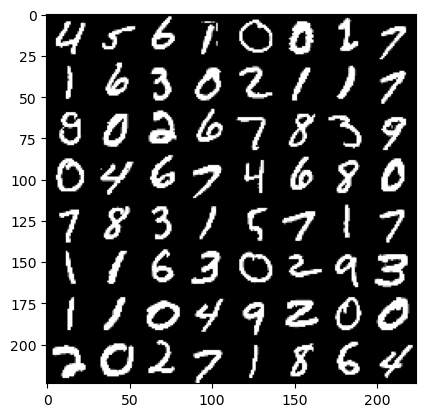

GroundTruth:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Predicted:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 8 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Train Epoch: 7 [640/60000 (1%)]	Loss: 0.004630
Train Epoch: 7 [1280/60000 (2%)]	Loss: 0.060101
Train Epoch: 7 [1920/60000 (3%)]	Loss: 0.091647
Train Epoch: 7 [2560/60000 (4%)]	Loss: 0.046547
Train Epoch: 7 [3200/60000 (5%)]	Loss: 0.034274
Train Epoch: 7 [3840/60000 (6%)]	Loss: 0.005992
Train Epoch: 7 [4480/60000 (7%)]	Loss: 0.044462
Train Epoch: 7 [5120/60000 (9%)]	Loss: 0.205586
Train Epoch: 7 [5760/60000 (10%)]	Loss: 0.168788
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.033544
Train Epoch: 7 [7040/60000 (12%)]	Loss: 0.075016
Train Epoch: 7 [7680/60000 (13%)]	Loss: 0.031172
Train Epoch: 7 [8320/60000 (14%)]	Loss: 0.031169
Train Epoch: 7 [8960/60000 (15%)]	Loss: 0.082066
Train Epoch: 7 [9600/60000 (16%)]	Loss: 0

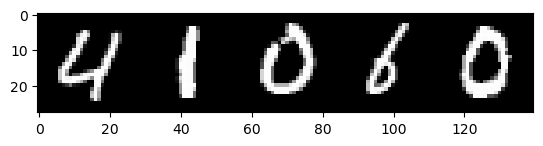

2.0
GroundTruth:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 6 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 7 1 5 3 4 6 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
Predicted:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 5 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 1 0 6 2 1 1 3 1 5 3 4 8 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
4.0
5.0
9.0
11.0
14.0
15.0
16.0
19.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19.0

Test set: Average loss: 0.0369, Accuracy: 9892/10000 (99%)

Accuracy of 0.000000 : 100 %
Accuracy of 1.000000 : 100 %
Accuracy of 2.000000 : 100 %
Accuracy of 3.000000 : 100 %
Accuracy of 4.000000 : 100 %
Accuracy of 5.000000 : 100 %
Accuracy of 6.000000 : 100 %
Accuracy of 7.000000 : 80 %
Accuracy of 8.000000 : 100 %
Accuracy of 9.000000 : 100 %
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Train Epoch: 8 [0/60000 (0%)]	Loss: 0.017271
(224, 224, 3)


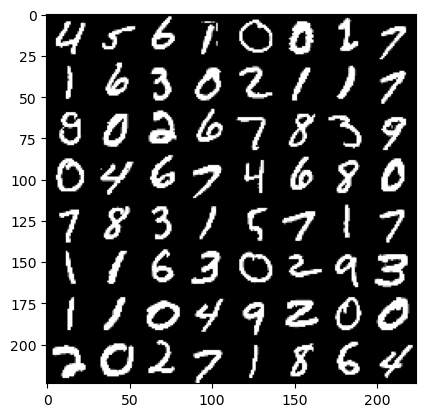

GroundTruth:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Predicted:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 8 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.012088
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.051657
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.067476
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.030285
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.003275
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.002898
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.057444
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.065844
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.061562
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.098949
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.013224
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.028004
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.022263
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.222533
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0

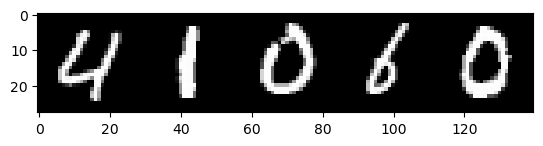

2.0
GroundTruth:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 6 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 7 1 5 3 4 6 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
Predicted:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 5 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 1 1 5 3 4 6 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
4.0
5.0
9.0
11.0
14.0
15.0
16.0
19.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19.0

Test set: Average loss: 0.0425, Accuracy: 9877/10000 (99%)

Accuracy of 0.000000 : 100 %
Accuracy of 1.000000 : 100 %
Accuracy of 2.000000 : 100 %
Accuracy of 3.000000 : 100 %
Accuracy of 4.000000 : 100 %
Accuracy of 5.000000 : 100 %
Accuracy of 6.000000 : 100 %
Accuracy of 7.000000 : 80 %
Accuracy of 8.000000 : 100 %
Accuracy of 9.000000 : 100 %
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Train Epoch: 9 [0/60000 (0%)]	Loss: 0.007855
(224, 224, 3)


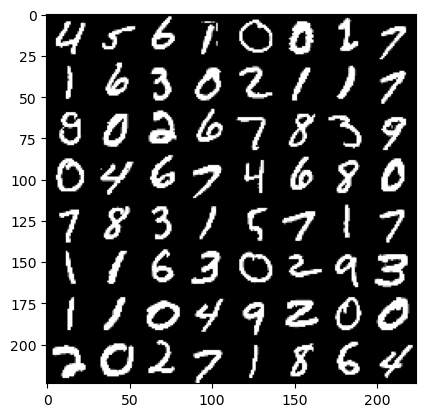

GroundTruth:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Predicted:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 8 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.010334
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.122210
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.149789
Train Epoch: 9 [2560/60000 (4%)]	Loss: 0.098848
Train Epoch: 9 [3200/60000 (5%)]	Loss: 0.009822
Train Epoch: 9 [3840/60000 (6%)]	Loss: 0.010956
Train Epoch: 9 [4480/60000 (7%)]	Loss: 0.093734
Train Epoch: 9 [5120/60000 (9%)]	Loss: 0.049149
Train Epoch: 9 [5760/60000 (10%)]	Loss: 0.152518
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.023158
Train Epoch: 9 [7040/60000 (12%)]	Loss: 0.171058
Train Epoch: 9 [7680/60000 (13%)]	Loss: 0.013751
Train Epoch: 9 [8320/60000 (14%)]	Loss: 0.027822
Train Epoch: 9 [8960/60000 (15%)]	Loss: 0.037744
Train Epoch: 9 [9600/60000 (16%)]	Loss: 0

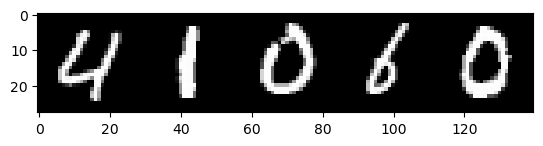

2.0
GroundTruth:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 6 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 7 1 5 3 4 6 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
Predicted:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 5 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 1 1 5 3 4 6 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
4.0
5.0
9.0
11.0
14.0
15.0
16.0
19.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19.0

Test set: Average loss: 0.0359, Accuracy: 9897/10000 (99%)

Accuracy of 0.000000 : 100 %
Accuracy of 1.000000 : 100 %
Accuracy of 2.000000 : 100 %
Accuracy of 3.000000 : 100 %
Accuracy of 4.000000 : 100 %
Accuracy of 5.000000 : 100 %
Accuracy of 6.000000 : 100 %
Accuracy of 7.000000 : 80 %
Accuracy of 8.000000 : 100 %
Accuracy of 9.000000 : 100 %
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Train Epoch: 10 [0/60000 (0%)]	Loss: 0.055472
(224, 224, 3)


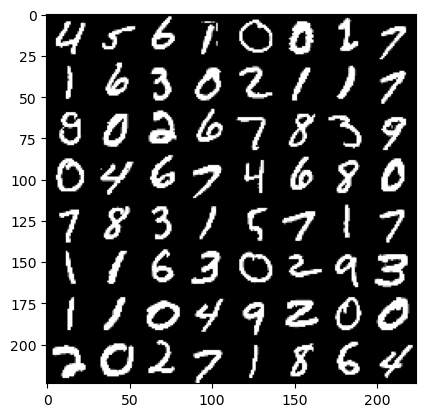

GroundTruth:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Predicted:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 0 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Train Epoch: 10 [640/60000 (1%)]	Loss: 0.006663
Train Epoch: 10 [1280/60000 (2%)]	Loss: 0.032665
Train Epoch: 10 [1920/60000 (3%)]	Loss: 0.148610
Train Epoch: 10 [2560/60000 (4%)]	Loss: 0.090124
Train Epoch: 10 [3200/60000 (5%)]	Loss: 0.038088
Train Epoch: 10 [3840/60000 (6%)]	Loss: 0.000337
Train Epoch: 10 [4480/60000 (7%)]	Loss: 0.017551
Train Epoch: 10 [5120/60000 (9%)]	Loss: 0.085397
Train Epoch: 10 [5760/60000 (10%)]	Loss: 0.047654
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.124405
Train Epoch: 10 [7040/60000 (12%)]	Loss: 0.020808
Train Epoch: 10 [7680/60000 (13%)]	Loss: 0.016585
Train Epoch: 10 [8320/60000 (14%)]	Loss: 0.019660
Train Epoch: 10 [8960/60000 (15%)]	Loss: 0.011004
Train Epoch: 10 [9600/60000

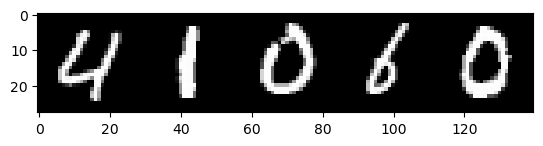

2.0
GroundTruth:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 6 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 7 1 5 3 4 6 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
Predicted:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 5 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 2 1 5 3 4 8 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
4.0
5.0
9.0
11.0
14.0
15.0
16.0
19.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19.0

Test set: Average loss: 0.0378, Accuracy: 9884/10000 (99%)

Accuracy of 0.000000 : 100 %
Accuracy of 1.000000 : 100 %
Accuracy of 2.000000 : 100 %
Accuracy of 3.000000 : 100 %
Accuracy of 4.000000 : 100 %
Accuracy of 5.000000 : 100 %
Accuracy of 6.000000 : 100 %
Accuracy of 7.000000 : 80 %
Accuracy of 8.000000 : 100 %
Accuracy of 9.000000 : 100 %
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Train Epoch: 11 [0/60000 (0%)]	Loss: 0.049338
(224, 224, 3)


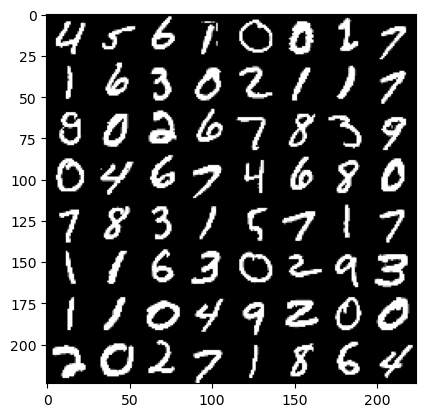

GroundTruth:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Predicted:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 8 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Train Epoch: 11 [640/60000 (1%)]	Loss: 0.019804
Train Epoch: 11 [1280/60000 (2%)]	Loss: 0.084108
Train Epoch: 11 [1920/60000 (3%)]	Loss: 0.060811
Train Epoch: 11 [2560/60000 (4%)]	Loss: 0.058502
Train Epoch: 11 [3200/60000 (5%)]	Loss: 0.028833
Train Epoch: 11 [3840/60000 (6%)]	Loss: 0.012721
Train Epoch: 11 [4480/60000 (7%)]	Loss: 0.009609
Train Epoch: 11 [5120/60000 (9%)]	Loss: 0.121441
Train Epoch: 11 [5760/60000 (10%)]	Loss: 0.036426
Train Epoch: 11 [6400/60000 (11%)]	Loss: 0.087874
Train Epoch: 11 [7040/60000 (12%)]	Loss: 0.208112
Train Epoch: 11 [7680/60000 (13%)]	Loss: 0.012587
Train Epoch: 11 [8320/60000 (14%)]	Loss: 0.039704
Train Epoch: 11 [8960/60000 (15%)]	Loss: 0.137288
Train Epoch: 11 [9600/60000

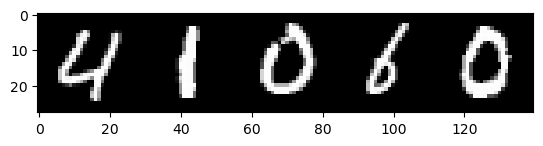

2.0
GroundTruth:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 6 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 7 1 5 3 4 6 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
Predicted:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 5 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 3 1 5 3 4 8 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
4.0
5.0
9.0
11.0
14.0
15.0
16.0
19.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19.0

Test set: Average loss: 0.0377, Accuracy: 9889/10000 (99%)

Accuracy of 0.000000 : 100 %
Accuracy of 1.000000 : 100 %
Accuracy of 2.000000 : 100 %
Accuracy of 3.000000 : 100 %
Accuracy of 4.000000 : 100 %
Accuracy of 5.000000 : 100 %
Accuracy of 6.000000 : 100 %
Accuracy of 7.000000 : 80 %
Accuracy of 8.000000 : 100 %
Accuracy of 9.000000 : 100 %
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Train Epoch: 12 [0/60000 (0%)]	Loss: 0.047292
(224, 224, 3)


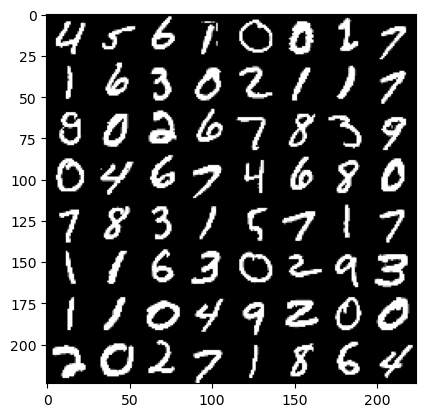

GroundTruth:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Predicted:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 8 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Train Epoch: 12 [640/60000 (1%)]	Loss: 0.014825
Train Epoch: 12 [1280/60000 (2%)]	Loss: 0.014155
Train Epoch: 12 [1920/60000 (3%)]	Loss: 0.146377
Train Epoch: 12 [2560/60000 (4%)]	Loss: 0.069086
Train Epoch: 12 [3200/60000 (5%)]	Loss: 0.030076
Train Epoch: 12 [3840/60000 (6%)]	Loss: 0.002666
Train Epoch: 12 [4480/60000 (7%)]	Loss: 0.033467
Train Epoch: 12 [5120/60000 (9%)]	Loss: 0.106718
Train Epoch: 12 [5760/60000 (10%)]	Loss: 0.081338
Train Epoch: 12 [6400/60000 (11%)]	Loss: 0.143846
Train Epoch: 12 [7040/60000 (12%)]	Loss: 0.072709
Train Epoch: 12 [7680/60000 (13%)]	Loss: 0.054927
Train Epoch: 12 [8320/60000 (14%)]	Loss: 0.023742
Train Epoch: 12 [8960/60000 (15%)]	Loss: 0.065440
Train Epoch: 12 [9600/60000

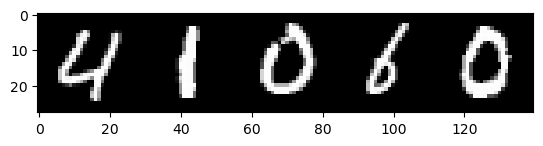

2.0
GroundTruth:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 6 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 7 1 5 3 4 6 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
Predicted:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 5 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 3 1 5 3 4 8 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
4.0
5.0
9.0
11.0
14.0
15.0
16.0
19.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19.0

Test set: Average loss: 0.0378, Accuracy: 9894/10000 (99%)

Accuracy of 0.000000 : 100 %
Accuracy of 1.000000 : 100 %
Accuracy of 2.000000 : 100 %
Accuracy of 3.000000 : 100 %
Accuracy of 4.000000 : 100 %
Accuracy of 5.000000 : 100 %
Accuracy of 6.000000 : 100 %
Accuracy of 7.000000 : 80 %
Accuracy of 8.000000 : 100 %
Accuracy of 9.000000 : 100 %
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Train Epoch: 13 [0/60000 (0%)]	Loss: 0.035530
(224, 224, 3)


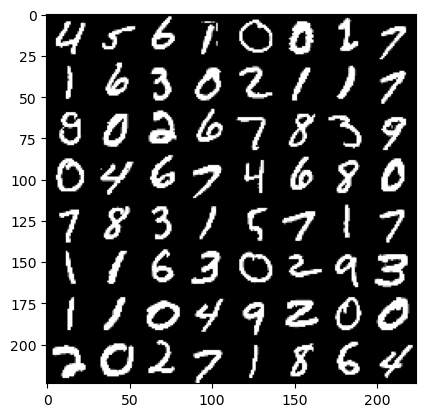

GroundTruth:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Predicted:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 5 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Train Epoch: 13 [640/60000 (1%)]	Loss: 0.019836
Train Epoch: 13 [1280/60000 (2%)]	Loss: 0.020661
Train Epoch: 13 [1920/60000 (3%)]	Loss: 0.188824
Train Epoch: 13 [2560/60000 (4%)]	Loss: 0.145166
Train Epoch: 13 [3200/60000 (5%)]	Loss: 0.064777
Train Epoch: 13 [3840/60000 (6%)]	Loss: 0.003966
Train Epoch: 13 [4480/60000 (7%)]	Loss: 0.044505
Train Epoch: 13 [5120/60000 (9%)]	Loss: 0.066516
Train Epoch: 13 [5760/60000 (10%)]	Loss: 0.034306
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.149827
Train Epoch: 13 [7040/60000 (12%)]	Loss: 0.035212
Train Epoch: 13 [7680/60000 (13%)]	Loss: 0.020426
Train Epoch: 13 [8320/60000 (14%)]	Loss: 0.049194
Train Epoch: 13 [8960/60000 (15%)]	Loss: 0.034514
Train Epoch: 13 [9600/60000

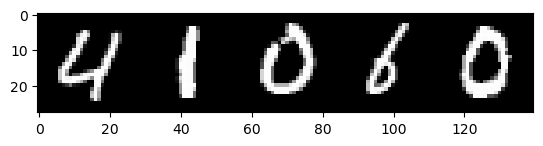

2.0
GroundTruth:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 6 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 7 1 5 3 4 6 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
Predicted:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 5 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 3 1 5 3 4 8 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
4.0
5.0
9.0
11.0
14.0
15.0
16.0
19.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


19.0

Test set: Average loss: 0.0356, Accuracy: 9895/10000 (99%)

Accuracy of 0.000000 : 100 %
Accuracy of 1.000000 : 100 %
Accuracy of 2.000000 : 100 %
Accuracy of 3.000000 : 100 %
Accuracy of 4.000000 : 100 %
Accuracy of 5.000000 : 100 %
Accuracy of 6.000000 : 100 %
Accuracy of 7.000000 : 80 %
Accuracy of 8.000000 : 100 %
Accuracy of 9.000000 : 100 %
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
Train Epoch: 14 [0/60000 (0%)]	Loss: 0.055285
(224, 224, 3)


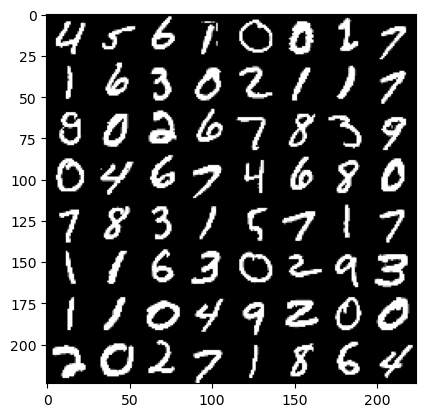

GroundTruth:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 9 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Predicted:  4 5 6 1 0 0 1 7 1 6 3 0 2 1 1 7 8 0 2 6 7 8 3 9 0 4 6 7 4 6 8 0 7 8 3 1 5 7 1 7 1 1 6 3 0 2 9 3 1 1 0 4 9 2 0 0 2 0 2 7 1 8 6 4
Train Epoch: 14 [640/60000 (1%)]	Loss: 0.007844
Train Epoch: 14 [1280/60000 (2%)]	Loss: 0.014185
Train Epoch: 14 [1920/60000 (3%)]	Loss: 0.214053
Train Epoch: 14 [2560/60000 (4%)]	Loss: 0.037553
Train Epoch: 14 [3200/60000 (5%)]	Loss: 0.079891
Train Epoch: 14 [3840/60000 (6%)]	Loss: 0.001179
Train Epoch: 14 [4480/60000 (7%)]	Loss: 0.036101
Train Epoch: 14 [5120/60000 (9%)]	Loss: 0.024499
Train Epoch: 14 [5760/60000 (10%)]	Loss: 0.015115
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.109737
Train Epoch: 14 [7040/60000 (12%)]	Loss: 0.153492
Train Epoch: 14 [7680/60000 (13%)]	Loss: 0.004640
Train Epoch: 14 [8320/60000 (14%)]	Loss: 0.006469
Train Epoch: 14 [8960/60000 (15%)]	Loss: 0.037431
Train Epoch: 14 [9600/60000

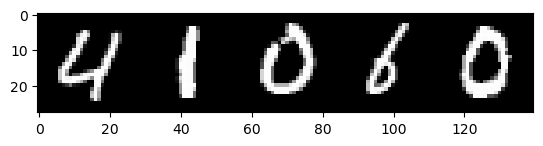

2.0
GroundTruth:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 6 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 7 1 5 3 4 6 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
Predicted:  9 0 2 5 1 9 7 8 1 0 4 1 7 9 5 4 2 6 8 1 3 7 5 4 4 1 8 1 3 8 1 2 5 8 0 6 2 1 1 3 1 5 3 4 8 9 5 0 9 2 2 4 8 2 1 7 2 4 9 4 4 0 3 9
4.0
5.0
9.0
11.0
14.0
15.0
16.0
19.0
19.0

Test set: Average loss: 0.0338, Accuracy: 9904/10000 (99%)

Accuracy of 0.000000 : 100 %
Accuracy of 1.000000 : 100 %
Accuracy of 2.000000 : 100 %
Accuracy of 3.000000 : 100 %
Accuracy of 4.000000 : 100 %
Accuracy of 5.000000 : 100 %
Accuracy of 6.000000 : 100 %
Accuracy of 7.000000 : 80 %
Accuracy of 8.000000 : 100 %
Accuracy of 9.000000 : 100 %
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0

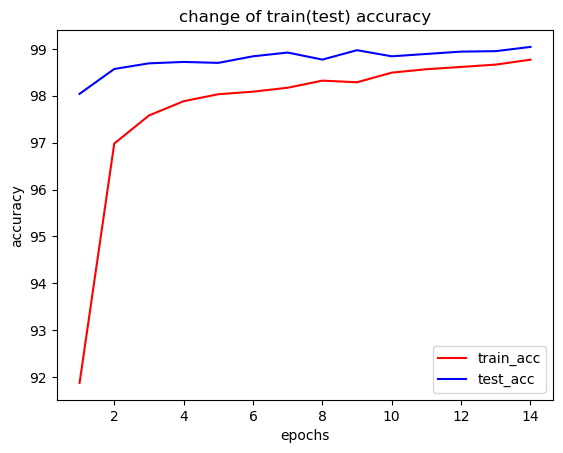

In [17]:
if __name__ == '__main__':
    main()
    